### Project Overview

Accidents resulting from defective railway tracks and derailments are a frequent and serious concern, especially in Southeast Asian countries. Early and accurate detection of track faults is critical to prevent such disasters. However, manual inspection methods are often time-consuming, labor-intensive, and expensive.

To address this, a series of four notebooks were developed to explore different automated fault detection approaches, using a publicly available railway track dataset from Kaggle:  
[Railway Track Fault Detection Dataset](https://www.kaggle.com/datasets/salmaneunus/railway-track-fault-detection).

1. **Classical Machine Learning(This Notebook):**  
   Using traditional techniques such as Support Vector Machine (SVM), Logistic Regression, and Random Forest classifiers on hand-crafted HOG features.

2. CNN-based Classification (without Augmentation):
   Training convolutional neural network models on the original dataset to classify defective and non-defective railway tracks.

3. CNN-based Classification (with Data Augmentation):
   Enhancing the training data through augmentation techniques to improve model generalization and robustness.

4. Anomaly Detection using Autoencoder:
   Training a UNet-style convolutional autoencoder exclusively on healthy track images and detecting faults based on reconstruction error analysis.

This multi-approach study provides a comprehensive evaluation of both classical and deep learning methods for automatic railway track fault detection.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Core Python Libraries
import os
import sys
import gc
import random as rnd
from tqdm import tqdm
from PIL import Image

# Data Handling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing Libraries
import cv2
import skimage
from skimage.feature import hog, canny
from skimage.filters import sobel
from skimage import color

# Scikit-learn Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation, Flatten,
                                     BatchNormalization, Conv2D, MaxPooling2D,
                                     AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import keras.backend as K

# Explainability Tools
from tf_explain.core.activations import ExtractActivations
from tf_explain.core.smoothgrad import SmoothGrad

# Miscellaneous
import pickle
from numpy import expand_dims

# Visualization for Training Progress
try:
    from livelossplot import PlotLossesKeras
except ImportError:
    !pip install livelossplot
    from livelossplot import PlotLossesKeras

# Enable inline plotting for notebooks
%matplotlib inline


## Dataset Organization

The dataset consists of railway track images categorized into two classes: Defective and Non-defective.
The images are split into three subsets:
- Train set
- Validation set
- Test set

Each subset contains separate folders for defective and non-defective samples.  
The number of samples in each category and subset was printed to verify correct dataset loading.

Additionally, all defective and non-defective samples across train, validation, and test sets were concatenated into two combined DataFrames (defective and undefective) for further analysis and visualization.

### Dataset Split Summary

The dataset was evenly split between defective and undefective railway track images across training, validation, and test sets:

- Training set: 150 defective and 150 undefective samples
- Validation set: 31 defective and 31 undefective samples
- Test set: 11 defective and 11 undefective samples

This balanced split ensures that both classes are equally represented during model training and evaluation, minimizing bias and providing a fair assessment of performance.



In [ ]:
train_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train'
val_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Validation'
test_path = '../input/railway-track-fault-detection/Railway Track fault Detection Updated/Test'

In [ ]:
train_df_defective = pd.DataFrame(os.listdir(train_path+'/Defective'))
val_df_defective = pd.DataFrame(os.listdir(val_path+'/Defective'))
test_df_defective = pd.DataFrame(os.listdir(test_path+'/Defective'))
train_df_undefective = pd.DataFrame(os.listdir(train_path+'/Non defective'))
val_df_undefective = pd.DataFrame(os.listdir(val_path+'/Non defective'))
test_df_undefective = pd.DataFrame(os.listdir(test_path+'/Non defective'))

In [ ]:
defective=pd.concat([train_df_defective,test_df_defective,val_df_defective], axis=0)
undefective=pd.concat([train_df_undefective,test_df_undefective,val_df_undefective], axis=0)

In [ ]:
# Print the number of defective and undefective samples in the training, validation, and test sets
print('Train samples defective: ', len(train_df_defective))
print('Val samples defective: ', len(val_df_defective))
print('Test samples defective: ', len(test_df_defective))
print()
print('Train samples undefective: ', len(train_df_undefective))
print('Val samples undefective: ', len(val_df_undefective))
print('Test samples undefective: ', len(test_df_undefective))

In [ ]:
# Display the first 31 defective training images after resizing them to 448x448 and print their original dimensions
plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_defective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, channels = img.shape

    print(f"Width: {width}, Height: {height}, Channels: {channels}")
    #Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


In [ ]:
# Display the first 31 undefective training images after resizing them to 448x448 for visual inspection

plt.figure(figsize=(15, 12))
for idx, image_path in enumerate(train_df_undefective[0]):
    if idx == 31:
        break
    plt.subplot(4, 8, idx + 1)

    # Read the image with OpenCV
    img = cv2.imread('../input/railway-track-fault-detection/Railway Track fault Detection Updated/Train/Non defective/' + image_path)

    # OpenCV loads images in BGR format, so convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image
    img = cv2.resize(img, (448, 448))

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(idx)

plt.tight_layout()
plt.show()


### HOG Feature Extraction

In this section, we extract Histogram of Oriented Gradients (HOG) features from the railway track images to create a feature set for classification.

- Grayscale Conversion: Each image is first converted to grayscale to simplify the feature extraction.
- Resizing: Images are resized to 128 times 128 pixels for uniformity.
- HOG Descriptor:
  - Captures the distribution of gradient orientations (edges) in localized regions of the image.
  - Parameters used:
    - pixels\_per\_cell = (16, 16)
    - cells\_per\_block = (2, 2)
  - Both the HOG feature vector and a visualization of the HOG representation are obtained.
- Label Assignment:
  - Defective images are labeled as \(1\).
  - Non-defective (healthy) images are labeled as \(0\).
- Visualization:
  - A few HOG-transformed images from both defective and non-defective classes are saved for visualization.

Finally, the HOG feature vectors X_train_features and the corresponding labels y_train_labels are stored as NumPy arrays for use in machine learning models.


In [ ]:
# Extract HOG (Histogram of Oriented Gradients) features for defective and non-defective images:
# - Convert images to grayscale
# - Resize images to 128x128 for uniformity
# - Extract HOG features with pixels_per_cell=(16,16) and cells_per_block=(2,2)
# - Store extracted features and labels
# - Save a few HOG visualizations for later analysis

X_train_features = []
y_train_labels = []

# For Visualization
hog_images_defective = []
hog_images_nondefective = []
count_defective = 0
count_nondefective = 0

# Defective images
for img_path in tqdm(train_df_defective[0]):
    img = cv2.imread(train_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))

    features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    X_train_features.append(features)
    y_train_labels.append(1)

    # Save HOG images for visualization (only 5)
    if count_defective < 5:
        hog_images_defective.append((img, hog_image))
        count_defective += 1

# Non-defective images
for img_path in tqdm(train_df_undefective[0]):
    img = cv2.imread(train_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))

    features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    X_train_features.append(features)
    y_train_labels.append(0)

    # Save HOG images for visualization (only 5)
    if count_nondefective < 5:
        hog_images_nondefective.append((img, hog_image))
        count_nondefective += 1

X_train_features = np.array(X_train_features)
y_train_labels = np.array(y_train_labels)

print("HOG feature extraction complete!")


In [ ]:
# Visualize original and HOG-transformed images:
# - Display 5 defective and 5 non-defective samples
# - Show side-by-side comparison: original grayscale image vs extracted HOG features
# - Help understand how HOG captures edge and gradient information from the tracks

# Plot defective samples
plt.figure(figsize=(12, 10))
for idx, (orig, hog_img) in enumerate(hog_images_defective):
    plt.subplot(5, 2, idx*2 + 1)
    plt.imshow(orig, cmap='gray')
    plt.title('Defective - Original')
    plt.axis('off')

    plt.subplot(5, 2, idx*2 + 2)
    plt.imshow(hog_img, cmap='gray')
    plt.title('Defective - HOG')
    plt.axis('off')

plt.suptitle('Defective Track Samples - Original vs HOG', fontsize=16)
plt.tight_layout()
plt.show()

# Plot non-defective samples
plt.figure(figsize=(12, 10))
for idx, (orig, hog_img) in enumerate(hog_images_nondefective):
    plt.subplot(5, 2, idx*2 + 1)
    plt.imshow(orig, cmap='gray')
    plt.title('Non-defective - Original')
    plt.axis('off')

    plt.subplot(5, 2, idx*2 + 2)
    plt.imshow(hog_img, cmap='gray')
    plt.title('Non-defective - HOG')
    plt.axis('off')

plt.suptitle('Non-Defective Track Samples - Original vs HOG', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Extract HOG features for validation images:
# - Convert validation images to grayscale
# - Resize images to 128x128
# - Extract HOG features with pixels_per_cell=(16,16) and cells_per_block=(2,2)
# - Assign labels: 1 for defective, 0 for non-defective
# - Store the extracted features and labels into NumPy arrays

X_val_features = []
y_val_labels = []

for img_path in tqdm(val_df_defective[0]):
    img = cv2.imread(val_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    X_val_features.append(features)
    y_val_labels.append(1)

for img_path in tqdm(val_df_undefective[0]):
    img = cv2.imread(val_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    X_val_features.append(features)
    y_val_labels.append(0)

X_val_features = np.array(X_val_features)
y_val_labels = np.array(y_val_labels)


In [ ]:
# Extract HOG features for test images:
# - Convert test images to grayscale
# - Resize images to 128x128
# - Extract HOG features with pixels_per_cell=(16,16) and cells_per_block=(2,2)
# - Assign labels: 1 for defective, 0 for non-defective
# - Store the extracted features and labels into NumPy arrays

X_test_features = []
y_test_labels = []

for img_path in tqdm(test_df_defective[0]):
    img = cv2.imread(test_path + '/Defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    X_test_features.append(features)
    y_test_labels.append(1)

for img_path in tqdm(test_df_undefective[0]):
    img = cv2.imread(test_path + '/Non defective/' + img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128, 128))
    features = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
    X_test_features.append(features)
    y_test_labels.append(0)

X_test_features = np.array(X_test_features)
y_test_labels = np.array(y_test_labels)


### SVM Classification and Hyperparameter Tuning

In this section, we train a Support Vector Machine (SVM) classifier using HOG features.

- GridSearchCV is used to perform hyperparameter tuning over a predefined grid:
  - \(C\) values: [0.1, 1, 10, 100]
  - Kernels: linear, RBF
  - Gamma settings: scale, auto (for RBF kernel)
- A 5-fold cross-validation is applied to find the best combination of parameters.
- The best SVM model is selected based on cross-validation accuracy.
- The trained model is then evaluated on both the validation and test sets, and the accuracies are reported.


In [ ]:
# Set up the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],          # Regularization strength
    'kernel': ['linear', 'rbf'],      # Linear or RBF kernel
    'gamma': ['scale', 'auto']        # Only used for RBF
}

# Initialize SVM
svm = SVC()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid,
                           cv=5,              # 5-fold cross-validation
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)         # Use all CPU cores


In [ ]:
grid_search.fit(X_train_features, y_train_labels)


In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


In [ ]:
# Validation Predictions
val_preds = best_svm.predict(X_val_features)

# Validation Accuracy
val_accuracy = accuracy_score(y_val_labels, val_preds)
print("Validation Accuracy (SVM):", val_accuracy)

# Validation F1 Score
val_f1 = f1_score(y_val_labels, val_preds, average='binary')
print("Validation F1 Score (SVM):", val_f1)

# Validation Confusion Matrix
cm_val = confusion_matrix(y_val_labels, val_preds)
print("Validation Confusion Matrix (SVM):")
print(cm_val)

# Display Confusion Matrix
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Non-Defective', 'Defective'])
disp_val.plot(cmap='Blues')
plt.title("Validation Confusion Matrix - SVM")
plt.show()


In [ ]:
# Predict on test set
test_preds = best_svm.predict(X_test_features)

# Accuracy
test_accuracy = accuracy_score(y_test_labels, test_preds)
print("Test Accuracy:", test_accuracy)

# F1 Score
f1 = f1_score(y_test_labels, test_preds, average='binary')  # For binary classification
print("F1 Score (binary):", f1)

# Confusion Matrix
cm = confusion_matrix(y_test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Defective', 'Defective'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM on Test Set")
plt.show()

# Classification Report
report = classification_report(y_test_labels, test_preds, target_names=['Non-Defective', 'Defective'])
print("Classification Report:")
print(report)




### Logistic Regression Classification and Hyperparameter Tuning

In this section, we train a Logistic Regression classifier using HOG features.

- GridSearchCV is used to perform hyperparameter tuning over the following grid:
  - \(C\) values: [0.01, 0.1, 1, 10, 100]
  - Penalty: \('l2'\)
  - Solver: \('liblinear'\), which works well for small datasets.
- The maximum number of iterations is set to 1000 to ensure convergence during training.
- A 5-fold cross-validation is applied to find the best set of hyperparameters.
- The best Logistic Regression model is selected based on cross-validation accuracy.
- The trained model is then evaluated on the validation and test sets, and the accuracies are reported.


In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],   # use 'l1' if you want sparse models
    'solver': ['liblinear']  # liblinear works well for small datasets
}


In [ ]:
log_reg = LogisticRegression(max_iter=1000)   # Set higher max_iter to ensure convergence

grid_search_lr = GridSearchCV(estimator=log_reg,
                              param_grid=param_grid_lr,
                              cv=5,
                              scoring='accuracy',
                              verbose=2,
                              n_jobs=-1)


In [ ]:
grid_search_lr.fit(X_train_features, y_train_labels)


In [ ]:
print("Best Hyperparameters (Logistic Regression):", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)


In [ ]:

# Validation Predictions
val_preds_lr = best_log_reg.predict(X_val_features)

# Validation Accuracy
val_accuracy_lr = accuracy_score(y_val_labels, val_preds_lr)
print("Validation Accuracy (Logistic Regression):", val_accuracy_lr)

# Validation F1 Score
val_f1_lr = f1_score(y_val_labels, val_preds_lr, average='binary')
print("Validation F1 Score (Logistic Regression):", val_f1_lr)

# Validation Confusion Matrix
cm_val_lr = confusion_matrix(y_val_labels, val_preds_lr)
print("Validation Confusion Matrix (Logistic Regression):")
print(cm_val_lr)

# Display Confusion Matrix
disp_val_lr = ConfusionMatrixDisplay(confusion_matrix=cm_val_lr, display_labels=['Non-Defective', 'Defective'])
disp_val_lr.plot(cmap='Blues')
plt.title("Validation Confusion Matrix - Logistic Regression")
plt.show()


In [ ]:
# Predict on test set
test_preds_lr = best_log_reg.predict(X_test_features)

# Accuracy
test_accuracy_lr = accuracy_score(y_test_labels, test_preds_lr)
print("Test Accuracy (Logistic Regression):", test_accuracy_lr)

# F1 Score
f1_lr = f1_score(y_test_labels, test_preds_lr, average='binary')
print("F1 Score (binary) (Logistic Regression):", f1_lr)

# Confusion Matrix
cm_lr = confusion_matrix(y_test_labels, test_preds_lr)
print("Confusion Matrix (Logistic Regression):")
print(cm_lr)

# Display Confusion Matrix
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Non-Defective', 'Defective'])
disp_lr.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression on Test Set")
plt.show()

# Classification Report
report_lr = classification_report(y_test_labels, test_preds_lr, target_names=['Non-Defective', 'Defective'])
print("Classification Report (Logistic Regression):")
print(report_lr)




### Random Forest Classification and Hyperparameter Tuning

In this section, we train a Random Forest classifier using HOG features.

- GridSearchCV is used to perform hyperparameter tuning over the following grid:
  - Number of estimators (\(n\_estimators\)): [50, 100, 200]
  - Maximum tree depth (\(max\_depth\)): [None, 10, 20, 30]
  - Minimum number of samples required to split an internal node (\(min\_samples\_split\)): [2, 5, 10]
  - Minimum number of samples required to be at a leaf node (\(min\_samples\_leaf\)): [1, 2, 4]
- A 5-fold cross-validation is applied to find the best set of hyperparameters.
- The best Random Forest model is selected based on cross-validation accuracy.
- The trained model is then evaluated on the validation and test sets, and the accuracies are reported.


In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
rf_clf = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid_rf,
                              cv=5,
                              scoring='accuracy',
                              verbose=2,
                              n_jobs=-1)


In [ ]:
grid_search_rf.fit(X_train_features, y_train_labels)


In [ ]:
print("Best Hyperparameters (Random Forest):", grid_search_rf.best_params_)
print("Best Cross-Validation Score:", grid_search_rf.best_score_)


In [ ]:
# Validation Predictions
val_preds_rf = best_rf.predict(X_val_features)

# Validation Accuracy
val_accuracy_rf = accuracy_score(y_val_labels, val_preds_rf)
print("Validation Accuracy (Random Forest):", val_accuracy_rf)

# Validation F1 Score
val_f1_rf = f1_score(y_val_labels, val_preds_rf, average='binary')
print("Validation F1 Score (Random Forest):", val_f1_rf)

# Validation Confusion Matrix
cm_val_rf = confusion_matrix(y_val_labels, val_preds_rf)
print("Validation Confusion Matrix (Random Forest):")
print(cm_val_rf)

# Display Confusion Matrix
disp_val_rf = ConfusionMatrixDisplay(confusion_matrix=cm_val_rf, display_labels=['Non-Defective', 'Defective'])
disp_val_rf.plot(cmap='Blues')
plt.title("Validation Confusion Matrix - Random Forest")
plt.show()


In [ ]:
# Predict on test set
test_preds_rf = best_rf.predict(X_test_features)

# Accuracy
test_accuracy_rf = accuracy_score(y_test_labels, test_preds_rf)
print("Test Accuracy (Random Forest):", test_accuracy_rf)

# F1 Score
f1_rf = f1_score(y_test_labels, test_preds_rf, average='binary')
print("F1 Score (binary) (Random Forest):", f1_rf)


# Confusion Matrix
cm_rf = confusion_matrix(y_test_labels, test_preds_rf)
print("Confusion Matrix (Random Forest):")
print(cm_rf)

# Display Confusion Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Non-Defective', 'Defective'])
disp_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()

# Classification Report
report_rf = classification_report(y_test_labels, test_preds_rf, target_names=['Non-Defective', 'Defective'])
print("Classification Report (Random Forest):")
print(report_rf)



In [ ]:
# Model names
models = ['SVM', 'Logistic Regression', 'Random Forest']

# Scores
val_accuracy = [0.7097, 0.6129, 0.5968]
test_accuracy = [0.5909, 0.5455, 0.5909]
val_f1 = [0.7188, 0.6471, 0.5763]
test_f1 = [0.5263, 0.4444, 0.4]

# X locations
x = np.arange(len(models))  # the label locations
width = 0.2  # width of the bars

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
rects1 = ax.bar(x - 1.5*width, val_accuracy, width, label='Validation Accuracy')
rects2 = ax.bar(x - 0.5*width, test_accuracy, width, label='Test Accuracy')
rects3 = ax.bar(x + 0.5*width, val_f1, width, label='Validation F1 Score')
rects4 = ax.bar(x + 1.5*width, test_f1, width, label='Test F1 Score')

# Labels and Title
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and F1 Score for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y')

# Save the plot
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)

# Show plot
plt.show()


CONFUSION MATRIX OF THE BEST PERFORMING MODEL-SVM:
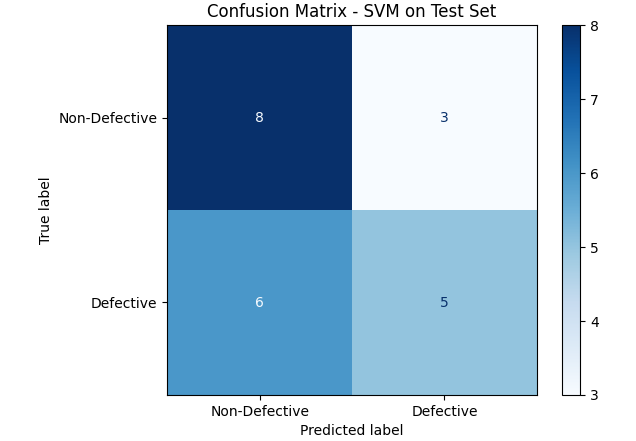

##Comparison of Different Algorithms:
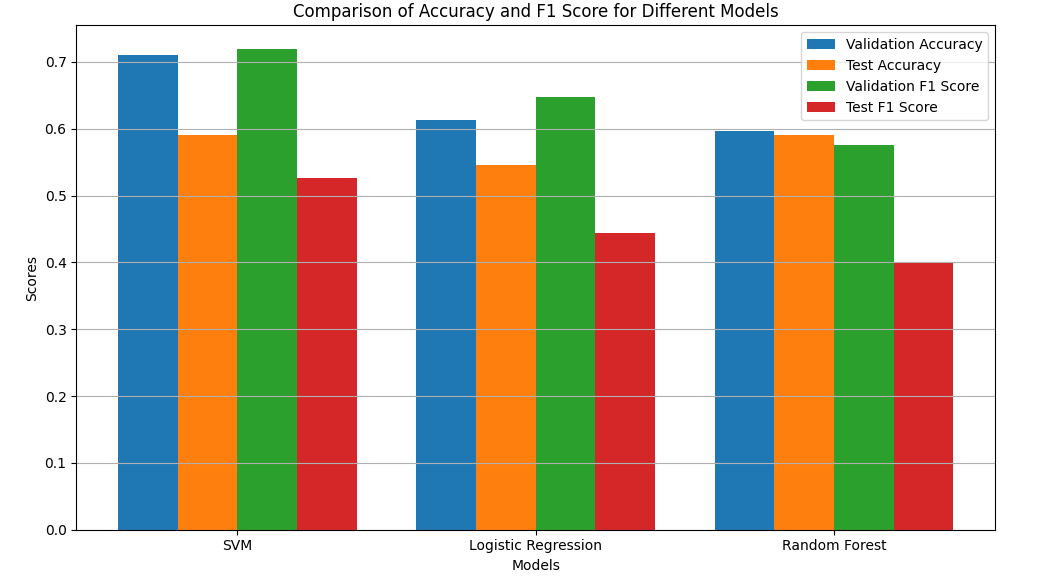

### Model Performance Comparison

The performance of three models — SVM, Logistic Regression, and Random Forest — was evaluated based on validation and test sets. Both accuracy and F1-score metrics were used to provide a comprehensive assessment.

The following table summarizes the results:

| Model                | Validation Accuracy | Test Accuracy | Validation F1 Score | Test F1 Score |
|----------------------|----------------------|---------------|---------------------|---------------|
| SVM                  | 0.7097               | 0.5909        | 0.7188              | 0.5263        |
| Logistic Regression  | 0.6129               | 0.5455        | 0.6471              | 0.4444        |
| Random Forest        | 0.5968               | 0.5909        | 0.5763              | 0.4000        |

The bar chart below visualizes these results, providing a direct comparison across different models.

From the analysis:
- SVM achieved the highest validation accuracy and F1 score, although its performance dropped slightly on the test set.
- Logistic Regression performed reasonably well but had lower F1 scores compared to SVM.
- Random Forest had comparable test accuracy to SVM but exhibited a lower F1 score, suggesting more false positives or false negatives.

Overall, SVM appears to offer the best trade-off between precision and recall among the models tested.
